In [1]:
import os
import numpy as np
import pandas as pd
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import cv2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential  
from keras.layers import Dropout, Flatten, Dense  
from keras.preprocessing import image as image_prepocessor


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data_path = "/home/paperspace/data/dogBreed/"
# data_path = r"D:\Projects\Datas\DogBreed"
im_size = 224

In [3]:
# df_train = pd.read_csv(os.path.join(data_path, "labels.csv"))
# df_test = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))

In [4]:
# df_train.head(10)

In [5]:
# targets_series = pd.Series(df_train["breed"])
# one_hot = pd.get_dummies(targets_series, sparse=True)

In [6]:
# one_hot_labels = np.asarray(one_hot)

In [7]:
# one_hot_labels.shape

In [8]:
# x_train = []
# y_train = []
# # x_test = []

In [9]:
def read_img(img_id, training, size):
    if training == 'train':
        file_path = _training_image_loc
    else:
        file_path = _testing_image_loc
    img = image_prepocessor.load_img(os.path.join(file_path, '%s.jpg' % img_id), target_size=size)
    img = image_prepocessor.img_to_array(img)
    return img

In [10]:
_training_image_loc = os.path.join(data_path, "train")
_training_label_loc = os.path.join(data_path, "labels.csv")
_testing_image_loc = os.path.join(data_path, "test")
_sample_sub_loc = os.path.join(data_path, "sample_submission.csv")

In [11]:
df = pd.read_csv(_training_label_loc, index_col=0)
dog_breeds, labels = np.unique(df.values, return_inverse=True)
no_of_breeds = len(dog_breeds)
labels = labels.reshape(-1, 1)
encoder = OneHotEncoder()
labels = encoder.fit_transform(labels)

In [12]:
list_of_imgs = np.array([read_img(img_id, "train", (im_size, im_size)) for img_id in tqdm(df.index.values)])

100%|██████████| 10222/10222 [00:34<00:00, 292.88it/s]


In [13]:
X_train, X_valid, Y_train, Y_valid = train_test_split(list_of_imgs, labels, test_size=0.2)

print(Y_train.shape)

(8177, 120)


In [14]:
X_train.shape

(8177, 224, 224, 3)

In [15]:
X_train[0, :, :, 0]

array([[115., 247., 109., ..., 173., 172., 172.],
       [ 86.,  90.,  24., ..., 175., 173., 173.],
       [103.,  78.,  98., ..., 173., 170., 170.],
       ...,
       [151., 158., 164., ...,   9.,   9.,   9.],
       [128., 165., 169., ...,   7.,   8.,   8.],
       [115., 133., 159., ...,   6.,   7.,   7.]], dtype=float32)

In [16]:
# i = 0
# for f, breed in tqdm(df_train.values):
#     img = cv2.imread(os.path.join(data_path, "train/{}.jpg".format(f)))
#     label = one_hot_labels[i]
#     x_train.append(cv2.resize(img, (im_size, im_size)))
#     y_train.append(label)
#     i += 1

In [17]:
# y_train_raw = np.array(y_train, np.uint8)
# x_train_raw = np.array(x_train, np.float32)/255.
# x_train = None

In [18]:
# print(x_train_raw.shape)
# print(y_train_raw.shape)
# # print(x_test.shape)

In [19]:
# num_class = y_train_raw.shape[1]

In [20]:
# # X_train, X_valid, Y_train, Y_valid = train_test_split(x_train_raw, y_train_raw, test_size=0.3, random_state=1)
# train_propotion = 0.8
# rnd = np.random.random(x_train_raw.shape[0])
# train_idx = rnd < train_propotion
# valid_idx = rnd >= train_propotion


In [21]:
# x_train_raw.size

In [22]:
# X_train, Y_train, X_valid, Y_valid = (x_train_raw[train_idx], y_train_raw[train_idx], 
#                                       x_train_raw[valid_idx], y_train_raw[valid_idx])
# x_train_raw = None
# y_train_raw = None

In [28]:
model = ResNet50(include_top=False, weights='imagenet')
bottleneck_features_train = model.predict(X_train)
# np.save("temp_train.npy", bottleneck_features_train)

bottleneck_features_val = model.predict(X_valid)
# np.save("temp_val.npy", bottleneck_features_val)  
bottleneck_features_val.shape

(2045, 1, 1, 2048)

In [25]:
# btl_shape = bottleneck_features_train.shape
# bottleneck_features_train = bottleneck_features_train.reshape(btl_shape[0], 1, 1, btl_shape[-1])

# btl_shape = bottleneck_features_val.shape
# bottleneck_features_val = bottleneck_features_val.reshape(btl_shape[0], 1, 1, btl_shape[-1])

# # (2045, 1, 1, 2048)


In [32]:
model = Sequential()
model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
model.add(Dense(1024, activation="relu"))
# model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(120, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy",
             metrics=["accuracy"])
history = model.fit(bottleneck_features_train, Y_train, epochs=25, batch_size=24,
                   validation_data=(bottleneck_features_val, Y_valid))

Train on 8177 samples, validate on 2045 samples
Epoch 1/25
8177/8177 [==============================] - 4s 466us/step - loss: 3.4878 - acc: 0.1937 - val_loss: 2.2074 - val_acc: 0.4259
Epoch 2/25
8177/8177 [==============================] - 2s 232us/step - loss: 2.2724 - acc: 0.3862 - val_loss: 1.8388 - val_acc: 0.4905
Epoch 3/25
8177/8177 [==============================] - 2s 240us/step - loss: 1.9129 - acc: 0.4601 - val_loss: 1.7383 - val_acc: 0.5012
Epoch 4/25
8177/8177 [==============================] - 2s 238us/step - loss: 1.7160 - acc: 0.5131 - val_loss: 1.6773 - val_acc: 0.5296
Epoch 5/25
8177/8177 [==============================] - 2s 241us/step - loss: 1.5643 - acc: 0.5386 - val_loss: 1.6434 - val_acc: 0.5408
Epoch 6/25
8177/8177 [==============================] - 2s 238us/step - loss: 1.4209 - acc: 0.5772 - val_loss: 1.6696 - val_acc: 0.5218
Epoch 7/25
8177/8177 [==============================] - 2s 237us/step - loss: 1.3208 - acc: 0.6045 - val_loss: 1.6574 - val_acc: 0.5335


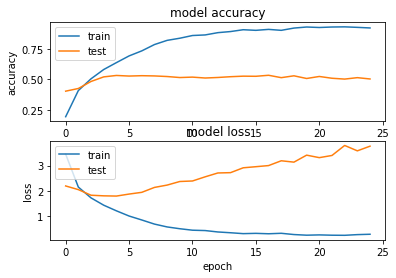

In [30]:
plt.figure(1)  
   
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(im_size, im_size, 3), pooling="avg")
train_model_op = base_model.predict(X_train, batch_size=32, verbose=1)
valid_model_op = base_model.predict(X_valid, batch_size=32, verbose=1)

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logreg.fit(train_model_op, (Y_train * range(num_class)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_model_op)
valid_preds = logreg.predict(valid_model_op)

print('Validation VGG LogLoss {}'.format(log_loss(Y_valid, valid_probs)))
print('Validation VGG Accuracy {}'.format(accuracy_score((Y_valid * range(num_class)).sum(axis=1), valid_preds)))

In [ ]:
valid_preds

In [ ]:
Y_valid

In [ ]:
# Resnet50
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(im_size, im_size, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(2048, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(num_class, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
callbacks_list = [keras.callbacks.EarlyStopping(monitor="val_acc", patience=3, 
                                               verbose=1)]
# model.summary()

In [ ]:
# Resnet50
model.fit(X_train, Y_train, epochs=25, 
          validation_data=(X_valid, Y_valid), verbose=1)

In [ ]:
# VGG
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(im_size, im_size, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(2048, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(num_class, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
callbacks_list = [keras.callbacks.EarlyStopping(monitor="val_acc", patience=3, 
                                               verbose=1)]
model.summary()

In [ ]:
# VGG
model.fit(X_train, Y_train, epochs=25, 
          validation_data=(X_valid, Y_valid), verbose=1)